In [25]:
import csv 
time_step = []
sunspots = []

In [26]:
with open('Datasets/Sunspots.csv') as file:
    read = csv.reader(file, delimiter = ',')
    next(read)
    for i in read:
        sunspots.append(float(i[2]))
        time_step.append(int(i[0]))

In [27]:
import numpy as np

series = np.array(sunspots)
time = np.array(time_step)

In [28]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [29]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

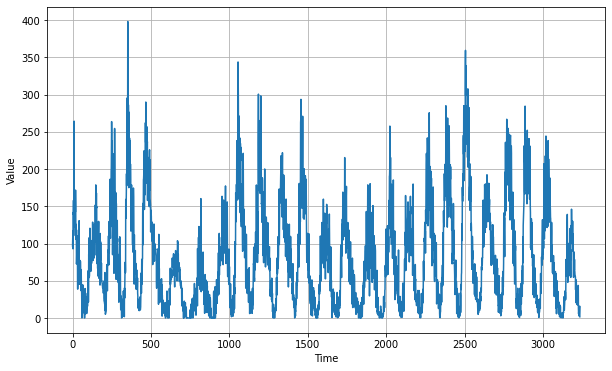

In [31]:
import matplotlib.pyplot as plt 

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time, series)

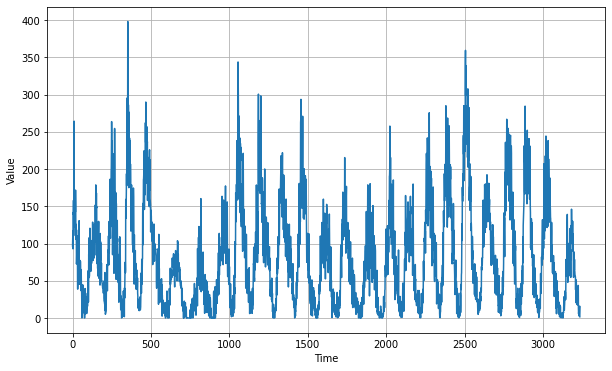

In [32]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [38]:
import tensorflow as tf 

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)


In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [40]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


In [41]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [42]:
history = model.fit(
    train_set, 
    epochs=100,
    callbacks=[lr_schedule],
    verbose = 1
    )

Epoch 1/100
4/4 [==============================] - 1s 204ms/step - loss: 69.8303 - mae: 70.3254
Epoch 2/100
4/4 [==============================] - 1s 189ms/step - loss: 69.6463 - mae: 70.1414
Epoch 3/100
4/4 [==============================] - 1s 180ms/step - loss: 69.3094 - mae: 69.8043
Epoch 4/100
4/4 [==============================] - 1s 179ms/step - loss: 68.8430 - mae: 69.3380
Epoch 5/100
4/4 [==============================] - 1s 175ms/step - loss: 68.2579 - mae: 68.7537
Epoch 6/100
4/4 [==============================] - 1s 173ms/step - loss: 67.5467 - mae: 68.0434
Epoch 7/100
4/4 [==============================] - 1s 189ms/step - loss: 66.6835 - mae: 67.1805
Epoch 8/100
4/4 [==============================] - 1s 270ms/step - loss: 65.6176 - mae: 66.1150
Epoch 9/100
4/4 [==============================] - 1s 233ms/step - loss: 64.3068 - mae: 64.8043
Epoch 10/100
4/4 [==============================] - 1s 297ms/step - loss: 62.7490 - mae: 63.2467
Epoch 11/100
4/4 [=====================

(1e-08, 0.0001, 0.0, 60.0)

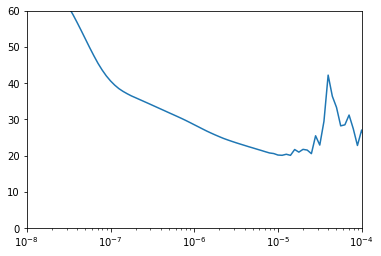

In [43]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

3836 - mae: 13.8659
Epoch 301/500
10/10 [==============================] - 1s 99ms/step - loss: 13.6092 - mae: 14.0910
Epoch 302/500
10/10 [==============================] - 1s 100ms/step - loss: 13.0399 - mae: 13.5212
Epoch 303/500
10/10 [==============================] - 1s 102ms/step - loss: 12.9307 - mae: 13.4117
Epoch 304/500
10/10 [==============================] - 1s 104ms/step - loss: 12.9084 - mae: 13.3894
Epoch 305/500
10/10 [==============================] - 1s 100ms/step - loss: 12.8249 - mae: 13.3052
Epoch 306/500
10/10 [==============================] - 1s 100ms/step - loss: 13.1625 - mae: 13.6437
Epoch 307/500
10/10 [==============================] - 1s 107ms/step - loss: 13.1539 - mae: 13.6355
Epoch 308/500
10/10 [==============================] - 1s 107ms/step - loss: 13.0537 - mae: 13.5349
Epoch 309/500
10/10 [==============================] - 1s 103ms/step - loss: 13.1198 - mae: 13.6009
Epoch 310/500
10/10 [==============================] - 1s 105ms/step - loss: 12.8

In [45]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

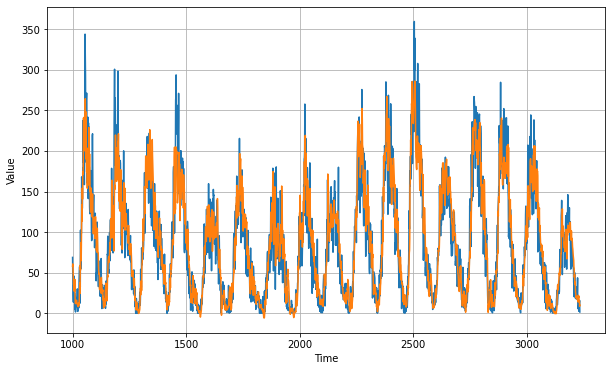

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

21.182518

<Figure size 432x288 with 0 Axes>

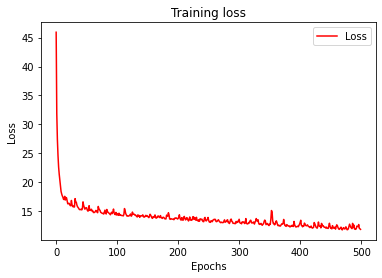

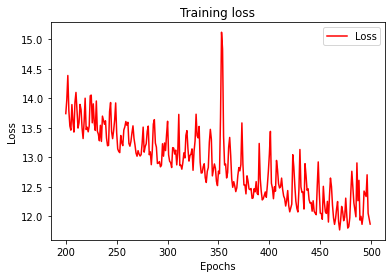

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epochs=range(len(loss)) 

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [49]:
print(rnn_forecast)

[57.97489  60.874413 55.536377 ... 15.267849  8.646017 10.106751]
